# Classify Groups (Standardized)

Decisions:
- Single-group samples; upstream code prefilters groups.
- Node features: `[coord, z, energy, view, group_energy]` (5 dims).
- Views use a single flag `view` (0=x-strip, 1=y-strip).
- Fully connected graphs per sample, built in the dataset (not in the model).
- Edge features always used: `[dx, dz, dE, same_view]` (4 dims).
- Models read `data.x`, `data.edge_index`, `data.edge_attr` only (no graph construction in forward).

In [1]:
import sys, os

PROJECT_ROOT = "/mnt/c/Users/obbee/research/notebooks/ML"
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
    os.environ["PYTHONPATH"] = PROJECT_ROOT + os.pathsep + os.environ.get("PYTHONPATH", "")

In [2]:
import math
import glob
import re
from pathlib import Path
from typing import List, Dict, Any, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch_geometric.loader import DataLoader

from graph_data.utils import GraphGroupDataset, GraphRecord
from graph_data.models import GroupClassifier

In [4]:

_CHUNK_INDEX_RE = re.compile(r"_(\d+)\.npy$")

PION_MASK = 0b00001
MUON_MASK = 0b00010
POSITRON_MASK = 0b00100
ELECTRON_MASK = 0b01000
OTHER_MASK = 0b10000

BIT_TO_CLASS = {
    PION_MASK: 0,
    MUON_MASK: 1,
    POSITRON_MASK: 2,  # positron collapses to mip label
    ELECTRON_MASK: 2,  # electron collapses to mip label
    # OTHER_MASK hits are ignored for supervision
}

CLASS_NAMES = {0: 'pion', 1: 'muon', 2: 'mip'}
NUM_GROUP_CLASSES = len(set(BIT_TO_CLASS.values()))


def _extract_file_index(path: Path) -> Optional[int]:
    """Return the numeric suffix from a chunk filename, if present."""
    match = _CHUNK_INDEX_RE.search(path.name)
    return int(match.group(1)) if match else None


def _labels_from_mask(mask: int) -> List[int]:
    """Decode a bitmask into class indices, collapsing e± into the MIP label."""
    labels = set()
    for bit, class_idx in BIT_TO_CLASS.items():
        if mask & bit:
            labels.add(class_idx)
    return list(labels)


def _count_labels(mask_values: np.ndarray) -> np.ndarray:
    """Count per-class hit occurrences for a group's bitmasks."""
    counts = np.zeros(NUM_GROUP_CLASSES, dtype=int)
    for mask in mask_values.astype(int):
        if mask <= 0:
            continue
        for class_idx in _labels_from_mask(mask):
            counts[class_idx] += 1
    return counts


def load_preprocessed_time_groups(
    file_pattern: str,
    *,
    max_files: Optional[int] = None,
    limit_groups: Optional[int] = None,
    min_hits: int = 2,
    min_hits_per_label: int = 2,
    verbose: bool = True,
) -> List[Dict[str, Any]]:
    """Load preprocessed time-group files into dictionaries for the dataset."""
    paths = [Path(p) for p in glob.glob(file_pattern)]
    if not paths:
        raise FileNotFoundError(f"No files matched pattern '{file_pattern}'")
    paths.sort(key=lambda p: (_extract_file_index(p) if _extract_file_index(p) is not None else math.inf, p.name))
    if max_files is not None:
        paths = paths[:max_files]

    records: List[Dict[str, Any]] = []
    label_totals = np.zeros(NUM_GROUP_CLASSES, dtype=int)

    for path in paths:
        if limit_groups is not None and len(records) >= limit_groups:
            break
        chunk = np.load(path, allow_pickle=True)
        for event_offset, event_groups in enumerate(chunk):
            if limit_groups is not None and len(records) >= limit_groups:
                break
            if event_groups is None or len(event_groups) == 0:
                continue
            for group_idx, group in enumerate(event_groups):
                if limit_groups is not None and len(records) >= limit_groups:
                    break
                group_arr = np.asarray(group)
                if group_arr.ndim != 2 or group_arr.shape[0] < min_hits or group_arr.shape[1] < 6:
                    continue

                mask_counts = _count_labels(group_arr[:, 5])
                labels = [cls for cls, count in enumerate(mask_counts) if count >= min_hits_per_label]
                if not labels:
                    labels = [cls for cls, count in enumerate(mask_counts) if count > 0]
                if not labels:
                    continue  # ignore groups without target particles

                record_event_id: Optional[int] = None
                if group_arr.shape[1] > 6:
                    try:
                        record_event_id = int(group_arr[0, 6])
                    except (ValueError, TypeError):
                        record_event_id = None
                if record_event_id is None:
                    chunk_idx = _extract_file_index(path) or 0
                    record_event_id = chunk_idx * 100000 + event_offset

                records.append({
                    'coord': group_arr[:, 0].astype(np.float32),
                    'z': group_arr[:, 1].astype(np.float32),
                    'energy': group_arr[:, 3].astype(np.float32),
                    'view': group_arr[:, 2].astype(np.float32),
                    'labels': labels,
                    'event_id': record_event_id,
                })
                for lbl in labels:
                    label_totals[lbl] += 1

    if not records:
        raise ValueError('No labeled groups found; adjust filtering thresholds.')

    if verbose:
        breakdown = ', '.join(f"{CLASS_NAMES.get(i, str(i))}: {int(label_totals[i])}" for i in range(NUM_GROUP_CLASSES))
        print(f"Loaded {len(records)} groups from {len(paths)} files ({breakdown})")

    return records


In [5]:

def _label_frequency(groups: List[Dict[str, Any]]) -> np.ndarray:
    counts = np.zeros(NUM_GROUP_CLASSES, dtype=int)
    for item in groups:
        label_list = list(item.get('labels') or [])
        if not label_list and item.get('label') is not None:
            label_list = [int(item['label'])]
        for lbl in label_list:
            if 0 <= lbl < NUM_GROUP_CLASSES:
                counts[lbl] += 1
    return counts


def _split_groups(groups: List[Dict[str, Any]], train_fraction: float, seed: int) -> Tuple[List[Dict[str, Any]], List[Dict[str, Any]]]:
    """Randomly split groups into train/validation subsets."""
    if len(groups) <= 1:
        return list(groups), []

    rng = np.random.default_rng(seed)
    indices = rng.permutation(len(groups))
    train_size = max(1, int(len(groups) * train_fraction))
    if train_size >= len(groups):
        train_size = len(groups) - 1

    train_idx = indices[:train_size]
    val_idx = indices[train_size:]
    train_groups = [groups[i] for i in train_idx]
    val_groups = [groups[i] for i in val_idx]
    return train_groups, val_groups


def _build_dataset(groups: List[Dict[str, Any]]) -> GraphGroupDataset:
    records = [GraphRecord(
        coord=g['coord'],
        z=g['z'],
        energy=g['energy'],
        view=g['view'],
        labels=g.get('labels'),
        event_id=g.get('event_id'),
        group_id=g.get('group_id'),
    ) for g in groups]
    return GraphGroupDataset(records, num_classes=NUM_GROUP_CLASSES)

def _make_loaders(
    groups: List[Dict[str, Any]],
    *,
    train_fraction: float,
    batch_size: int,
    seed: int,
):
    """Prepare torch_geometric loaders for training and validation."""
    train_groups, val_groups = _split_groups(groups, train_fraction, seed)
    train_dataset = _build_dataset(train_groups)
    val_dataset = _build_dataset(val_groups) if val_groups else None
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) if val_dataset else None
    return train_loader, val_loader, train_groups, val_groups


def _init_confusion() -> np.ndarray:
    return np.zeros((NUM_GROUP_CLASSES, 2, 2), dtype=np.int64)


def _update_confusion(confusion: np.ndarray, logits: torch.Tensor, targets: torch.Tensor, threshold: float) -> None:
    probs = torch.sigmoid(logits)
    preds = (probs >= threshold).int().cpu().numpy()
    target_np = targets.int().cpu().numpy()
    for cls_idx in range(target_np.shape[1]):
        truth = target_np[:, cls_idx]
        pred = preds[:, cls_idx]
        tn = ((truth == 0) & (pred == 0)).sum()
        fp = ((truth == 0) & (pred == 1)).sum()
        fn = ((truth == 1) & (pred == 0)).sum()
        tp = ((truth == 1) & (pred == 1)).sum()
        confusion[cls_idx, 0, 0] += tn
        confusion[cls_idx, 0, 1] += fp
        confusion[cls_idx, 1, 0] += fn
        confusion[cls_idx, 1, 1] += tp


def _exact_match_accuracy(logits: torch.Tensor, targets: torch.Tensor, threshold: float) -> float:
    probs = torch.sigmoid(logits)
    preds = (probs >= threshold).float()
    if preds.numel() == 0:
        return float('nan')
    return (preds == targets).all(dim=1).float().mean().item()


def _confusion_metrics(confusion: np.ndarray) -> np.ndarray:
    metrics = []
    for cls_idx in range(confusion.shape[0]):
        tn, fp = confusion[cls_idx, 0]
        fn, tp = confusion[cls_idx, 1]
        row = np.array([tp, fp, fn], dtype=float)
        total = row.sum()
        if total > 0:
            row /= total
        metrics.append(row)
    return np.vstack(metrics) if metrics else np.zeros((0, 3), dtype=float)


def _plot_confusion(title: str, confusion: np.ndarray, epoch: int) -> np.ndarray:
    metrics = _confusion_metrics(confusion)
    class_names = [CLASS_NAMES[idx] for idx in range(NUM_GROUP_CLASSES)]
    metric_names = ['true pos', 'false pos', 'false neg']

    fig, ax = plt.subplots(figsize=(5, 3.5))
    im = ax.imshow(metrics, cmap='Blues', vmin=0.0, vmax=1.0)
    ax.set_title(f"{title} confusion — epoch {epoch}")
    ax.set_xticks(range(len(metric_names)))
    ax.set_xticklabels(metric_names, rotation=30, ha='right')
    ax.set_yticks(range(len(class_names)))
    ax.set_yticklabels(class_names)

    for i in range(metrics.shape[0]):
        for j in range(metrics.shape[1]):
            value = metrics[i, j]
            text_color = 'white' if value > 0.6 else 'black'
            ax.text(j, i, f"{value:.5f}", ha='center', va='center', color=text_color)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
    return metrics


def _run_train_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module,
    device: torch.device,
    grad_clip: Optional[float],
    threshold: float,
) -> Tuple[float, float, np.ndarray]:
    model.train()
    total_loss = 0.0
    total_exact = 0.0
    total_examples = 0
    confusion = _init_confusion()

    for batch in loader:
        batch = batch.to(device)
        targets = batch.y.view(batch.num_graphs, -1).float()
        logits = model(batch)
        loss = loss_fn(logits, targets)

        optimizer.zero_grad()
        loss.backward()
        if grad_clip is not None:
            clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        batch_size = targets.size(0)
        total_loss += loss.item() * batch_size
        total_exact += _exact_match_accuracy(logits.detach(), targets, threshold) * batch_size
        total_examples += batch_size
        _update_confusion(confusion, logits.detach(), targets, threshold)

    avg_loss = total_loss / max(total_examples, 1)
    avg_exact = total_exact / max(total_examples, 1)
    return avg_loss, avg_exact, confusion


def _run_eval_epoch(
    model: nn.Module,
    loader: DataLoader,
    loss_fn: nn.Module,
    device: torch.device,
    threshold: float,
) -> Tuple[float, float, np.ndarray]:
    model.eval()
    total_loss = 0.0
    total_exact = 0.0
    total_examples = 0
    confusion = _init_confusion()

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            targets = batch.y.view(batch.num_graphs, -1).float()
            logits = model(batch)
            loss = loss_fn(logits, targets)

            batch_size = targets.size(0)
            total_loss += loss.item() * batch_size
            total_exact += _exact_match_accuracy(logits, targets, threshold) * batch_size
            total_examples += batch_size
            _update_confusion(confusion, logits, targets, threshold)

    if total_examples == 0:
        return float('nan'), float('nan'), confusion

    avg_loss = total_loss / total_examples
    avg_exact = total_exact / total_examples
    return avg_loss, avg_exact, confusion


def train_group_classifier(
    groups: List[Dict[str, Any]],
    *,
    model: Optional[GroupClassifier] = None,
    batch_size: int = 128,
    epochs: int = 20,
    lr: float = 1e-3,
    weight_decay: float = 1e-4,
    train_fraction: float = 0.9,
    seed: int = 42,
    device: Optional[str] = None,
    threshold: float = 0.5,
    grad_clip: Optional[float] = None,
    scheduler_step_size: Optional[int] = 5,
    scheduler_gamma: float = 0.5,
):
    """Train the GroupClassifier on preprocessed time-group data."""
    if not groups:
        raise ValueError('No groups provided for training.')

    device_str = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    device_obj = torch.device(device_str)

    model = model or GroupClassifier(num_classes=NUM_GROUP_CLASSES)
    model = model.to(device_obj)

    train_loader, val_loader, train_groups, val_groups = _make_loaders(
        groups, train_fraction=train_fraction, batch_size=batch_size, seed=seed
    )

    train_counts = _label_frequency(train_groups)
    val_counts = _label_frequency(val_groups) if val_groups else None

    total_train = max(len(train_groups), 1)
    pos_weight_vals = []
    for cls_idx in range(NUM_GROUP_CLASSES):
        positives = train_counts[cls_idx]
        negatives = total_train - positives
        if positives <= 0:
            pos_weight_vals.append(1.0)
        else:
            pos_weight_vals.append(negatives / positives)
    pos_weight = torch.tensor(pos_weight_vals, dtype=torch.float32, device=device_obj)

    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = None
    if scheduler_step_size is not None and scheduler_step_size > 0:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

    history = []
    for epoch in range(1, epochs + 1):
        current_lr = optimizer.param_groups[0]['lr']
        train_loss, train_exact, train_conf = _run_train_epoch(
            model, train_loader, optimizer, loss_fn, device_obj, grad_clip, threshold
        )
        val_loss, val_exact, val_conf = (None, None, None)
        if val_loader is not None:
            val_loss, val_exact, val_conf = _run_eval_epoch(
                model, val_loader, loss_fn, device_obj, threshold
            )

        if scheduler is not None:
            scheduler.step()

        if val_loss is not None and not np.isnan(val_loss):
            print(
                f"Epoch {epoch:02d} | lr={current_lr:.5f} | train_loss={train_loss:.5f} exact={train_exact:.5f} "
                f"| val_loss={val_loss:.5f} exact={val_exact:.5f}"
            )
        else:
            print(
                f"Epoch {epoch:02d} | lr={current_lr:.5f} | train_loss={train_loss:.5f} exact={train_exact:.5f}"
            )

        train_metrics = _plot_confusion('Train', train_conf, epoch)
        val_metrics = None
        if val_conf is not None:
            val_metrics = _plot_confusion('Val', val_conf, epoch)

        history.append({
            'epoch': epoch,
            'lr': current_lr,
            'train_loss': float(train_loss),
            'train_exact_match': float(train_exact),
            'train_confusion': train_conf.tolist(),
            'train_metrics': train_metrics.tolist(),
            'val_loss': None if val_loss is None or np.isnan(val_loss) else float(val_loss),
            'val_exact_match': None if val_exact is None or np.isnan(val_exact) else float(val_exact),
            'val_confusion': None if val_conf is None else val_conf.tolist(),
            'val_metrics': None if val_metrics is None else val_metrics.tolist(),
        })

    return {
        'model': model,
        'history': history,
        'train_counts': train_counts.astype(int).tolist(),
        'val_counts': val_counts.astype(int).tolist() if val_counts is not None else None,
        'pos_weight': pos_weight_vals,
    }


Loaded 100000 groups from 4 files (pion: 34014, muon: 34154, mip: 34019)
Epoch 01 | lr=0.00050 | train_loss=0.04256 exact=0.97429 | val_loss=0.00977 exact=0.99620


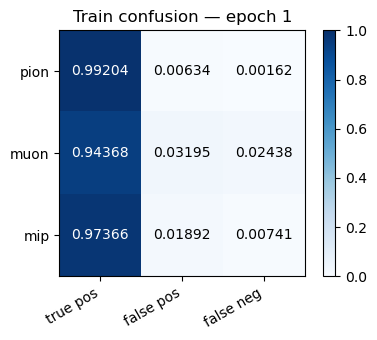

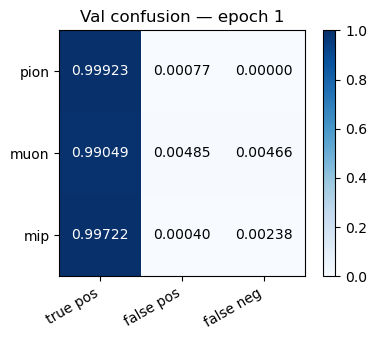

Epoch 02 | lr=0.00050 | train_loss=0.01345 exact=0.99361 | val_loss=0.00783 exact=0.99653


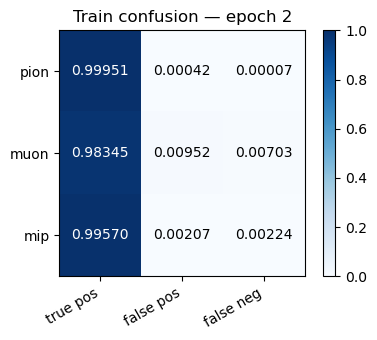

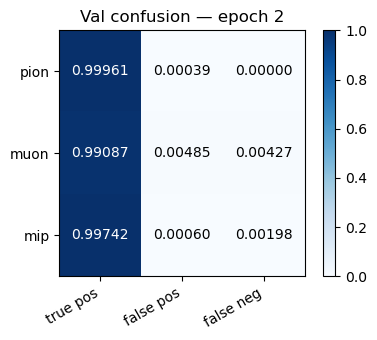

Epoch 03 | lr=0.00050 | train_loss=0.01373 exact=0.99420 | val_loss=0.00963 exact=0.99653


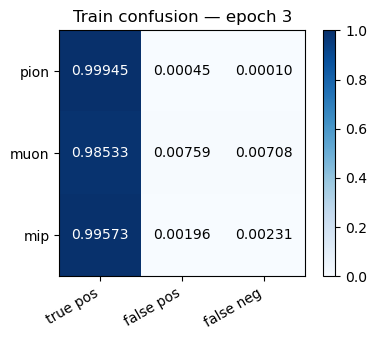

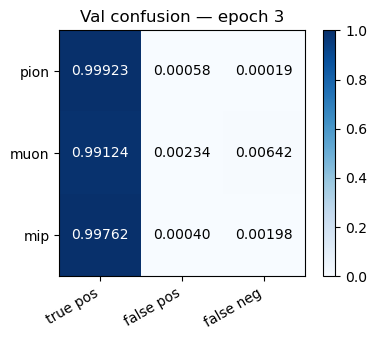

KeyboardInterrupt: 

In [6]:

# Example pipeline: load preprocessed groups and train the classifier

FILE_PATTERN = '/mnt/e/testML/pimuTimeGroups/mainTimeGroups_*.npy'

groups = load_preprocessed_time_groups(
    FILE_PATTERN,
    max_files=4,            # adjust based on available memory
    limit_groups=100000,     # cap total groups for quicker iterations
    min_hits=1,
    min_hits_per_label=2,
)

model = GroupClassifier(num_classes=NUM_GROUP_CLASSES, hidden=200, num_blocks=2, dropout=0.05)

results = train_group_classifier(
    groups,
    model=model,
    batch_size=128,
    epochs=20,
    lr=5e-4,
    weight_decay=1e-5,
    train_fraction=0.85,
    seed=123,
    grad_clip=2.0,
    threshold=0.5,
)

name_seq = [CLASS_NAMES[i] for i in range(NUM_GROUP_CLASSES)]
print('Class distribution (train):', dict(zip(name_seq, results['train_counts'])))
if results['val_counts'] is not None:
    print('Class distribution (val):', dict(zip(name_seq, results['val_counts'])))
print('Positive class weights:', dict(zip(name_seq, [round(w, 3) for w in results['pos_weight']])))

print('Training history snapshot:')
for entry in results['history']:
    if entry['val_loss'] is not None:
        print(
            f"  Epoch {entry['epoch']:02d}: "
            f"train_loss={entry['train_loss']:.4f}, exact={entry['train_exact_match']:.3f}, "
            f"val_loss={entry['val_loss']:.4f}, val_exact={entry['val_exact_match']:.3f}"
        )
    else:
        print(
            f"  Epoch {entry['epoch']:02d}: "
            f"train_loss={entry['train_loss']:.4f}, exact={entry['train_exact_match']:.3f}"
        )
